# 1. Descriptive Statistics

## 1.1 Basic Example

### 1.1.1 Download

In [1]:
import pandas as pd
import requests
import io
import os

def download_macro_data(url):
    """Downloads macroeconomic data from a URL and returns a pandas DataFrame."""
    print(f"Fetching macroeconomic data from: {url}")
    df = pd.read_stata(url)
    return df
url_macro = 'https://github.com/KMueller-Lab/Global-Macro-Database/raw/refs/heads/main/data/final/chainlinked_unemp.dta'
df_unemp_raw = download_macro_data(url_macro)
df_unemp_raw.head(2)

Fetching macroeconomic data from: https://github.com/KMueller-Lab/Global-Macro-Database/raw/refs/heads/main/data/final/chainlinked_unemp.dta


,ISO3,year,ADB_unemp,AFDB_unemp,AHSTAT_unemp,AMECO_unemp,EUS_unemp,HFS_unemp,ILO_unemp,IMF_IFS_unemp,IMF_WEO_unemp,JST_unemp,OECD_EO_unemp,OECD_KEI_unemp,CS1_unemp,unemp,chainlinking_ratio,source,source_change
0,ZWE,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,9.348,NaN,NaN,NaN,NaN,NaN,NaN,9.348,1.0,ILO,1.0
1,ZWE,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,10.087,10.139,NaN,NaN,NaN,NaN,NaN,10.139,1.0,IMF_IFS,NaN


### 1.1.2 Filter

In [2]:
df_unemp = df_unemp_raw[['ISO3', 'year', 'unemp']]
df_unemp.head(2)

,ISO3,year,unemp
0,ZWE,2023.0,9.348
1,ZWE,2022.0,10.139


### 1.1.3 Show descriptive stats

In [3]:
df_unemp['unemp'].describe()

count    7645.000000
mean        7.686186
std         6.259881
min         0.000000
25%         3.475000
50%         6.058000
75%         9.800000
max        70.000000
Name: unemp, dtype: float64

<Axes: >

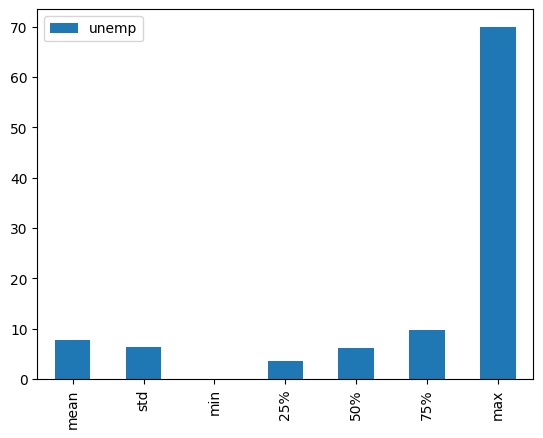

In [4]:
df_unemp['unemp'].describe().drop(['count'], axis = 0).to_frame().plot(kind = 'bar')

## 1.2 Groupby

### 1.2.1 By Country

In [5]:
df_unemp_descriptive_bycountry = df_unemp.groupby('ISO3')['unemp'].describe()
df_unemp_descriptive_bycountry.head(2)

,count,mean,std,min,25%,50%,75%,max
ISO3,,,,,,,,
ABW,39.0,7.088641,1.902090,3.250,6.05350,6.90000,8.70000,11.4
AFG,13.0,8.300230,7.950102,1.692,3.37019,3.37046,8.22908,23.9


In [6]:
df_plot = df_unemp_descriptive_bycountry['mean'].head(5).sort_values()
df_plot

ISO3
ABW     7.088641
AFG     8.300230
ALB    12.198080
AGO    14.545181
AIA    16.000000
Name: mean, dtype: float64

Text(0.5, 1.0, 'Mean unemployment by country over sample')

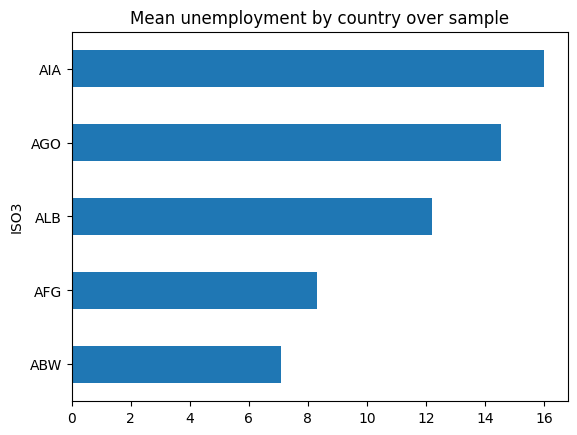

In [7]:
import matplotlib.pyplot as plt
df_plot.plot(kind = 'barh')
plt.title("Mean unemployment by country over sample")

#### Refresher: (1) on using dictionary to rename (2) filter specific country rows

In [8]:
# Website with country codes https://www.iban.com/country-codes
country_code = pd.read_html('https://www.iban.com/country-codes')[0]
country_code.head(2)

,Country,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,AF,AFG,4
1,Åland Islands,AX,ALA,248


In [9]:
country_map = dict(country_code[['Alpha-3 code', 'Country']].values)
#country_map

In [10]:
country_list = ["JPY", "GIB", "FRA"]
df_plot = df_unemp_descriptive_bycountry['max'].rename(country_map, axis='index').sort_values()
df_plot.head(2)

ISO3
Qatar    1.480
Benin    2.647
Name: max, dtype: float64

In [11]:
df_plot = df_plot.to_frame().query("ISO3 in ['France', 'Japan', 'China', 'Greece']")
df_plot.head(2)

,max
ISO3,
China,5.617
Japan,6.800


Text(0.5, 1.0, 'Max Unemployment by Country in Sample')

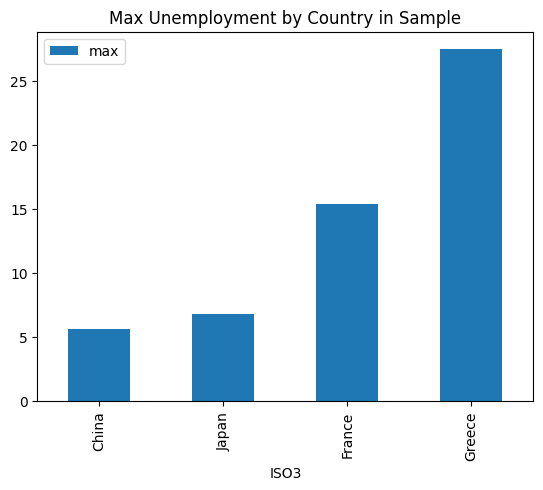

In [12]:
df_plot.plot(kind = 'bar')
plt.title("Max Unemployment by Country in Sample")

### 1.2.2 Groupby date

In [13]:
df_unemp_datetime = df_unemp.copy()
df_unemp_datetime.year = pd.to_datetime(df_unemp_datetime.year, format = "%Y")
df_unemp_datetime.head(2)

,ISO3,year,unemp
0,ZWE,2023-01-01,9.348
1,ZWE,2022-01-01,10.139


In [14]:
df_unemp_descriptive_bydate = df_unemp.groupby('year')['unemp'].describe()
df_unemp_descriptive_bydate.head(2)

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1760.0,1.0,3.626304,NaN,3.626304,3.626304,3.626304,3.626304,3.626304
1761.0,1.0,3.114833,NaN,3.114833,3.114833,3.114833,3.114833,3.114833


<Axes: xlabel='year'>

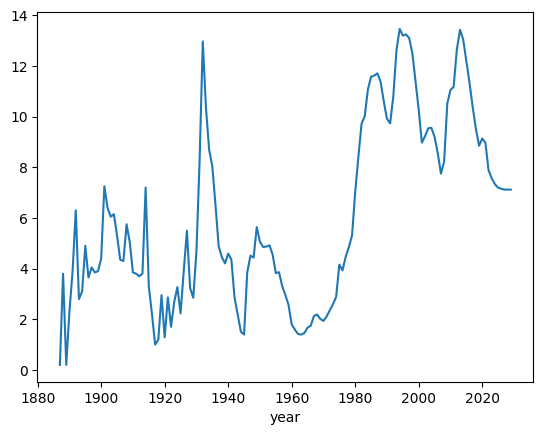

In [15]:
df_unemp.query("ISO3 in ['FRA', 'DEU', 'ESP', 'ITA']").groupby('year')['unemp'].mean().plot()

# 2. Plot time series

## 2.A Download Worldbank data

In [16]:
import requests
import pandas as pd

def download_worldbank(indicator, countries, date_start, date_end):
    url_base = 'http://api.worldbank.org/v2/'  # Base URL for the World Bank API
    country_codes = ';'.join(countries)  # Combine country codes into a string
    url = url_base + f'country/{country_codes}/indicator/{indicator}?date={date_start}:{date_end}&per_page=30000' #create the url with start and end date.
    url = url_base + f'country/{country_codes}/indicator/{indicator}?per_page=30000' # This line overrides the previous one. It will ignore start/end date.

    response = requests.get(url)  # Download data from the URL
    df = pd.read_xml(response.content)  # Convert the downloaded data to a table
    df['series'] = indicator
    df['date'] = pd.to_datetime(df['date'], format = "%Y")

    return df  # Return the table

In [17]:
# Example 1
df_wb = download_worldbank(
    indicator = 'NY.GDP.PCAP.CD' , 
    countries = ['US', 'CA', 'MX', 'JP'],  
    date_start = '2020', 
    date_end = '2023'
)
df_wb.head(2)

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal,series
0,GDP per capita (current US$),Canada,CAN,2024-01-01,NaN,NaN,NaN,1,NY.GDP.PCAP.CD
1,GDP per capita (current US$),Canada,CAN,2023-01-01,53431.185706,NaN,NaN,1,NY.GDP.PCAP.CD


## 2.1 Plot Panel Data

### 2.1.1 Pivot function data from long to panel

In [18]:
df_wb_long = df_wb.pivot(
    index = ['countryiso3code', 'date'],
    columns = ['series'],
    values = 'value'
    )
df_wb_long.head(2)

series                      NY.GDP.PCAP.CD
countryiso3code date                      
CAN             1960-01-01     2264.948497
                1961-01-01     2246.083566

In [19]:
df_wb_long = df_wb_long.reset_index()
df_wb_long.head(2)

series,countryiso3code,date,NY.GDP.PCAP.CD
0,CAN,1960-01-01,2264.948497
1,CAN,1961-01-01,2246.083566


### 2.1.2 Plot panel data with seaborn

<Axes: xlabel='date', ylabel='NY.GDP.PCAP.CD'>

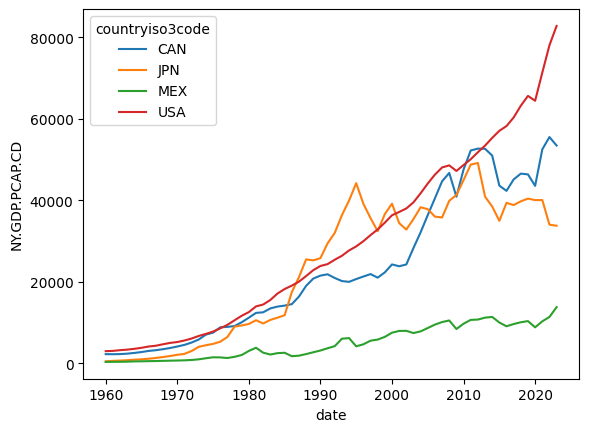

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing plt explicitly for clarity

sns.lineplot(
    data = df_wb_long,      # Dataframe with long format data
    x = 'date',                   # Column for x-axis (dates)
    y = 'NY.GDP.PCAP.CD',         # Column for y-axis (GDP values)
    hue = 'countryiso3code'               # Column for color differentiation (countries)
)


## 2.2 Plot Wide Data

### 2.2.1 Pivot function data from long to wide

In [21]:
df_wb_wide = df_wb_long.pivot(
     index = [ 'date'],
    columns = ['countryiso3code'],
    values = 'NY.GDP.PCAP.CD'
    )
df_wb_wide.head(2)

countryiso3code,CAN,JPN,MEX,USA
date,,,,
1960-01-01,2264.948497,508.702779,355.075200,2999.864872
1961-01-01,2246.083566,608.864581,373.712217,3059.160821


<Axes: xlabel='date'>

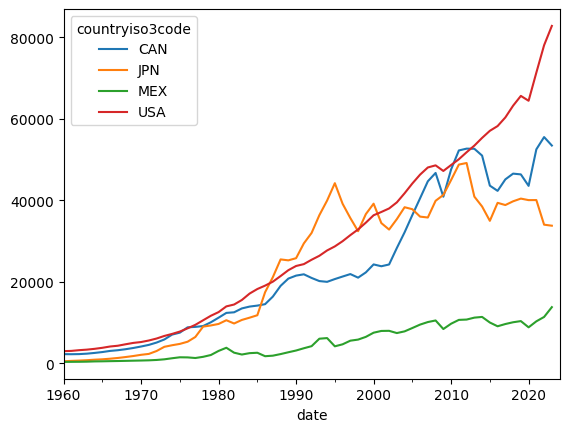

In [22]:
df_wb_wide.plot(kind = 'line')

## 2.3 Customize plot with matplotlib

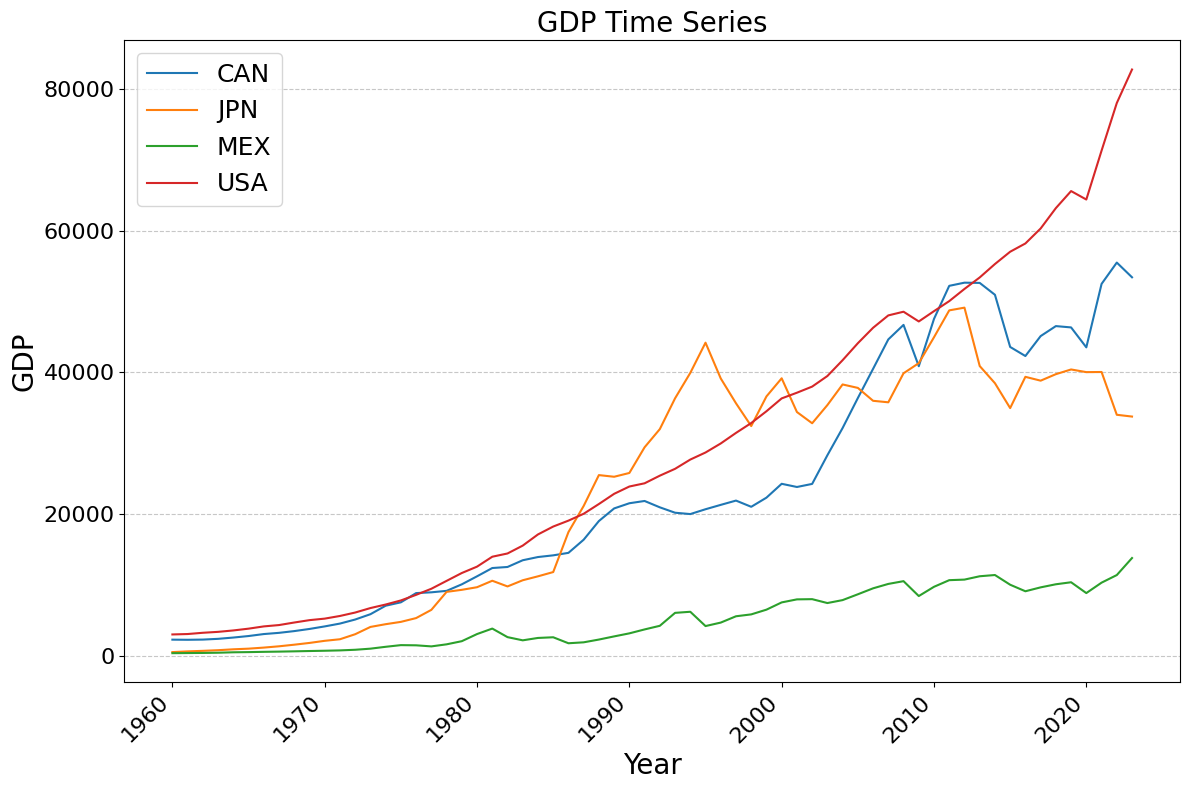

<Figure size 640x480 with 0 Axes>

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing plt explicitly for clarity


# Set plot size (width, height) in inches
plt.figure(figsize=(12, 8))  # Increased plot size (larger than default)

sns.lineplot(
    data = df_wb_long,      # Dataframe with long format data
    x = 'date',                   # Column for x-axis (dates)
    y = 'NY.GDP.PCAP.CD',         # Column for y-axis (GDP values)
    hue = 'countryiso3code'               # Column for color differentiation (countries)
)

# Customizing plot labels and title
plt.ylabel("GDP", size = 20)      # Y-axis label with font size 20
plt.xlabel("Year", size = 20)     # X-axis label with font size 20
plt.title("GDP Time Series", size = 20)  # Plot title with font size 20

# Additional customizations
plt.xticks(rotation=45, ha='right')  # Rotate x-axis tick labels for readability
plt.yticks(size=14)                  # Set y-axis tick label font size to 14
plt.tick_params(axis='both', labelsize=16)  # Uniform tick label font size for both axes
plt.legend(fontsize=18, loc='upper left')  # Customize legend font size and location
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add a dashed grid for y-axis
plt.tight_layout()                   # Ensure labels fit within the figure area

# Display and Save the plot
plt.show()                           # Display the plot
plt.savefig('gdp_time_series.png',   # Save plot as PNG
            dpi=120,                 # Set resolution (dots per inch)
            bbox_inches='tight',     # Remove excess whitespace
            transparent=False)       # Background transparency (False = opaque)

# 3. Create visualization functions

## 3.1 Create data pipeline in Notebook

### 3.1.1 Download

In [24]:
import requests
import pandas as pd

def download_worldbank(indicator, countries, date_start, date_end):
    url_base = 'http://api.worldbank.org/v2/'  # Base URL for the World Bank API
    country_codes = ';'.join(countries)  # Combine country codes into a string
    url = url_base + f'country/{country_codes}/indicator/{indicator}?date={date_start}:{date_end}&per_page=30000' #create the url with start and end date.
    url = url_base + f'country/{country_codes}/indicator/{indicator}?per_page=30000' # This line overrides the previous one. It will ignore start/end date.

    response = requests.get(url)  # Download data from the URL
    df = pd.read_xml(response.content)  # Convert the downloaded data to a table
    df['series'] = indicator
    df['date'] = pd.to_datetime(df['date'], format = "%Y")

    return df  # Return the table

# Example 1
df_wb = download_worldbank(
    indicator = 'MS.MIL.XPND.GD.ZS' ,
    countries = ['US', 'CA', 'MX', 'JP'],
    date_start = '2020',
    date_end = '2023'
)
df_wb.head(2)

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal,series
0,Military expenditure (% of GDP),Canada,CAN,2024-01-01,NaN,NaN,NaN,1,MS.MIL.XPND.GD.ZS
1,Military expenditure (% of GDP),Canada,CAN,2023-01-01,1.293001,NaN,NaN,1,MS.MIL.XPND.GD.ZS


In [25]:
df_wb.to_csv("data/raw.csv")

### 3.1.2 Manipulated

In [26]:
def pivot_worldbank_data(df):
    df_pivot = df.pivot(
        index = ['countryiso3code', 'date'],
        columns = ['series'],
        values = 'value'
    ).reset_index()
    return df_pivot

df_wb_pivot = pivot_worldbank_data(df_wb)
df_wb_pivot.head(2)

series,countryiso3code,date,MS.MIL.XPND.GD.ZS
0,CAN,1960-01-01,4.185257
1,CAN,1961-01-01,4.128312


In [27]:
def rename_convert_wide(df, column_country, column_date, datetime_format = '%Y-%m-%d'):
    data = df.rename({column_date : 'date', column_country : 'country'}, axis=1)
    data['date'] = pd.to_datetime(data['date'], format = datetime_format)
    #data = data.set_index(['country', 'date'])
    return data
df_wb_long_final = rename_convert_wide(df = df_wb_pivot,  column_country = 'countryiso3code', column_date = 'date', datetime_format = '%Y')
df_wb_long_final.head(2)

series,country,date,MS.MIL.XPND.GD.ZS
0,CAN,1960-01-01,4.185257
1,CAN,1961-01-01,4.128312


In [28]:
df_wb_long_final.to_csv("data/cleaned.csv")

### 3.1.3 Plot Descriptive Statistics

<Axes: >

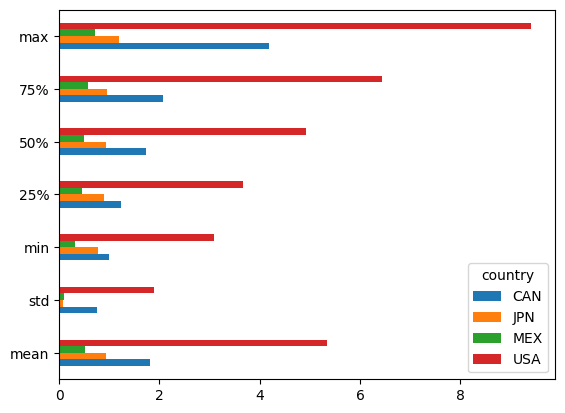

In [29]:
df_wb_long_final.groupby("country")['MS.MIL.XPND.GD.ZS'].describe().drop(['count'], axis = 'columns').transpose().plot(kind = 'barh')

### 3.1.4 Plot Time series

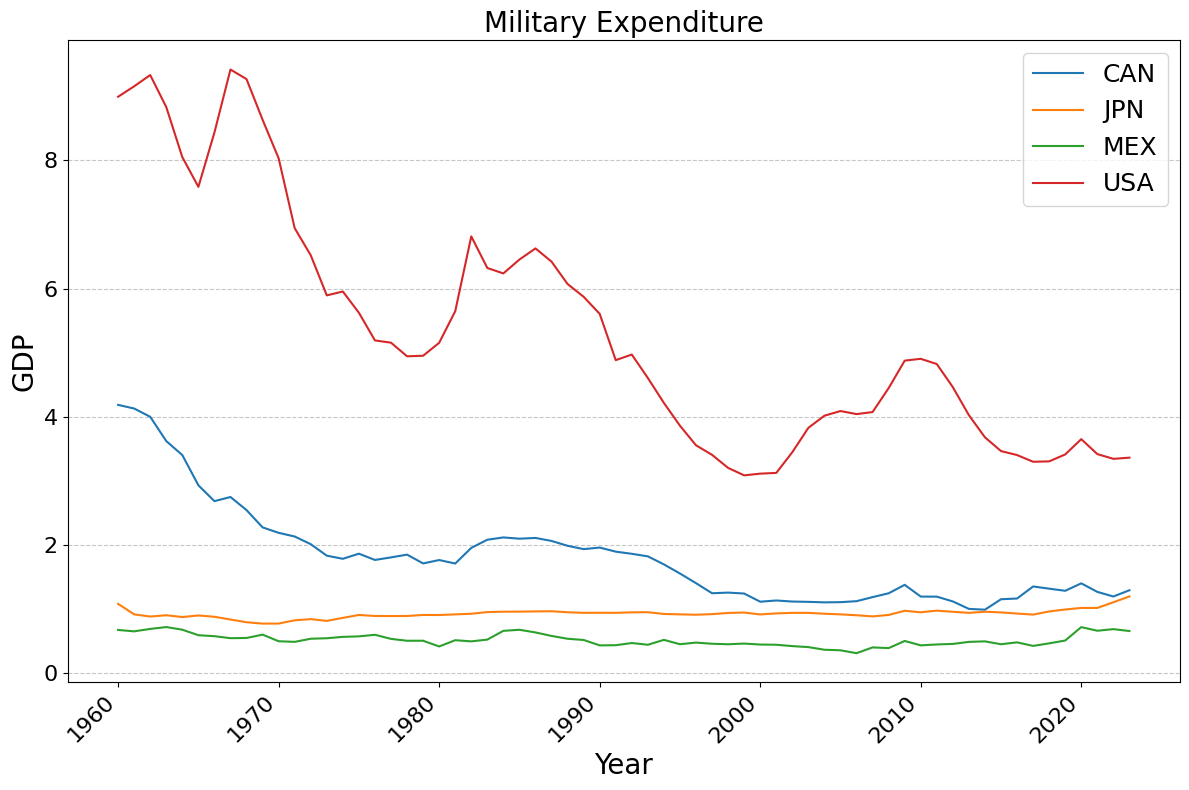

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ts(df, x_col, y_col, hue_col, title, filename = False):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df, x=x_col, y=y_col, hue=hue_col)
    plt.ylabel("GDP", size=20)
    plt.xlabel("Year", size=20)
    plt.title(title, size=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(size=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.legend(fontsize=18, loc='best')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=120, bbox_inches='tight', transparent=False)

plot_ts(
    df = df_wb_long_final,
    x_col = 'date', 
    y_col = 'MS.MIL.XPND.GD.ZS', 
    hue_col = 'country', 
    title = 'Military Expenditure', 
    filename = False
)

## 3.2 Create data pipeline in class

In [31]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class PipelineWBDescriptive:
    def __init__(self, indicator, countries, date_start=None, date_end=None):
        self.indicator = indicator
        self.countries = countries
        self.date_start = date_start
        self.date_end = date_end
        self.url_base = 'http://api.worldbank.org/v2/'
        self.df = None
        self.df_pivot = None
        self.df_final = None        

    def download(self, save_data=False):
        country_codes = ';'.join(self.countries)
        url = f'country/{country_codes}/indicator/{self.indicator}?per_page=30000'
        if self.date_start and self.date_end:
            url += f'&date={self.date_start}:{self.date_end}'
        url = self.url_base + url
        response = requests.get(url)
        self.df = pd.read_xml(response.content)
        self.df['series'] = self.indicator
        self.df['date'] = pd.to_datetime(self.df['date'], format="%Y")
        if save_data:
            print(f"data save here: data/raw_{self.indicator}.csv')")
            self.df.to_csv(f'data/raw_{self.indicator}.csv')
        return self.df

    def pivot(self):
        self.df_pivot = self.df.pivot(index=['countryiso3code', 'date'], columns=['series'], values='value').reset_index()
        return self.df_pivot

    def rename_convert(self, save_data=False):
        self.df_final = self.df_pivot.rename({'countryiso3code': 'country', 'date': 'date'}, axis=1)
        self.df_final['date'] = pd.to_datetime(self.df_final['date'], format='%Y')
        if save_data:
            print(f"data save here: cleaned_{self.indicator}.csv")
            self.df_final.to_csv(f'data/cleaned_{self.indicator}.csv')
        return self.df_final

    def plot_timeseries(self, title='Military Expenditure', filename=False):
        
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=self.df_final, x='date', y=self.indicator, hue='country')
        plt.ylabel("GDP", size=20)
        plt.xlabel("Year", size=20)
        plt.title(title, size=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(size=14)
        plt.tick_params(axis='both', labelsize=16)
        plt.legend(fontsize=18, loc='best')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        if filename:
            print(f"time series saved here reports/{filename}")
            plt.savefig(f"reports/{filename}.png", dpi=120, bbox_inches='tight', transparent=False)
        plt.show()

    def plot_descriptive(self, title='Descriptive Statistics', filename=False):
        
        desc_stats = self.df_final.groupby("country")[self.indicator].describe().drop(['count'], axis = 'columns').transpose().plot(kind = 'barh')
        desc_stats.plot(kind='barh', figsize=(12, 8), title=title)
        plt.xlabel("Value", size=16)
        plt.ylabel("Country", size=16)
        plt.legend(fontsize=14, loc='best')
        plt.title(title)
        plt.tight_layout()
        if filename:
            print(f"time series saved here reports/{filename}")
            plt.savefig(f"reports/{filename}.png", dpi=120, bbox_inches='tight', transparent=False)
        plt.show()

# Example Usage
analyze = PipelineWBDescriptive(
    indicator='MS.MIL.XPND.GD.ZS',
    countries=['US', 'CA', 'MX', 'JP'],
    date_start='2020',
    date_end='2023'
)

In [32]:
df = analyze.download(save_data = True)
df.head(2)

data save here: data/raw_MS.MIL.XPND.GD.ZS.csv')


,indicator,country,countryiso3code,date,value,unit,obs_status,decimal,series
0,Military expenditure (% of GDP),Canada,CAN,2023-01-01,1.293001,NaN,NaN,1,MS.MIL.XPND.GD.ZS
1,Military expenditure (% of GDP),Canada,CAN,2022-01-01,1.195778,NaN,NaN,1,MS.MIL.XPND.GD.ZS


In [33]:
df = analyze.pivot()
df.head(2)

series,countryiso3code,date,MS.MIL.XPND.GD.ZS
0,CAN,2020-01-01,1.400836
1,CAN,2021-01-01,1.267294


In [34]:
df = analyze.rename_convert(save_data = True)
df.head(2)

data save here: cleaned_MS.MIL.XPND.GD.ZS.csv


series,country,date,MS.MIL.XPND.GD.ZS
0,CAN,2020-01-01,1.400836
1,CAN,2021-01-01,1.267294


time series saved here reports/descriptive_military


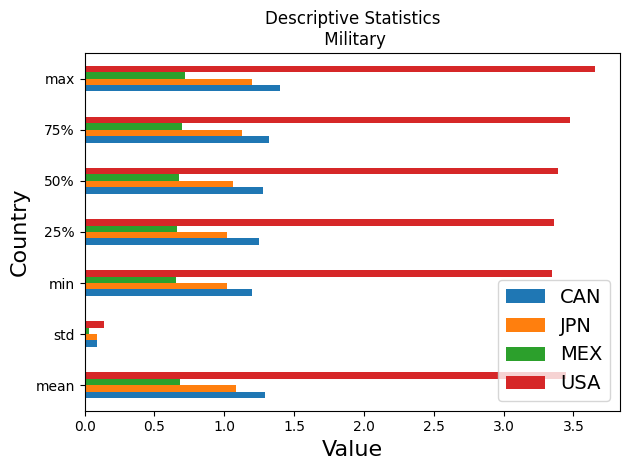

In [35]:
analyze.plot_descriptive(
    title = "Descriptive Statistics\n Military",
    filename = 'descriptive_military'
)

time series saved here reports/timeseries_military


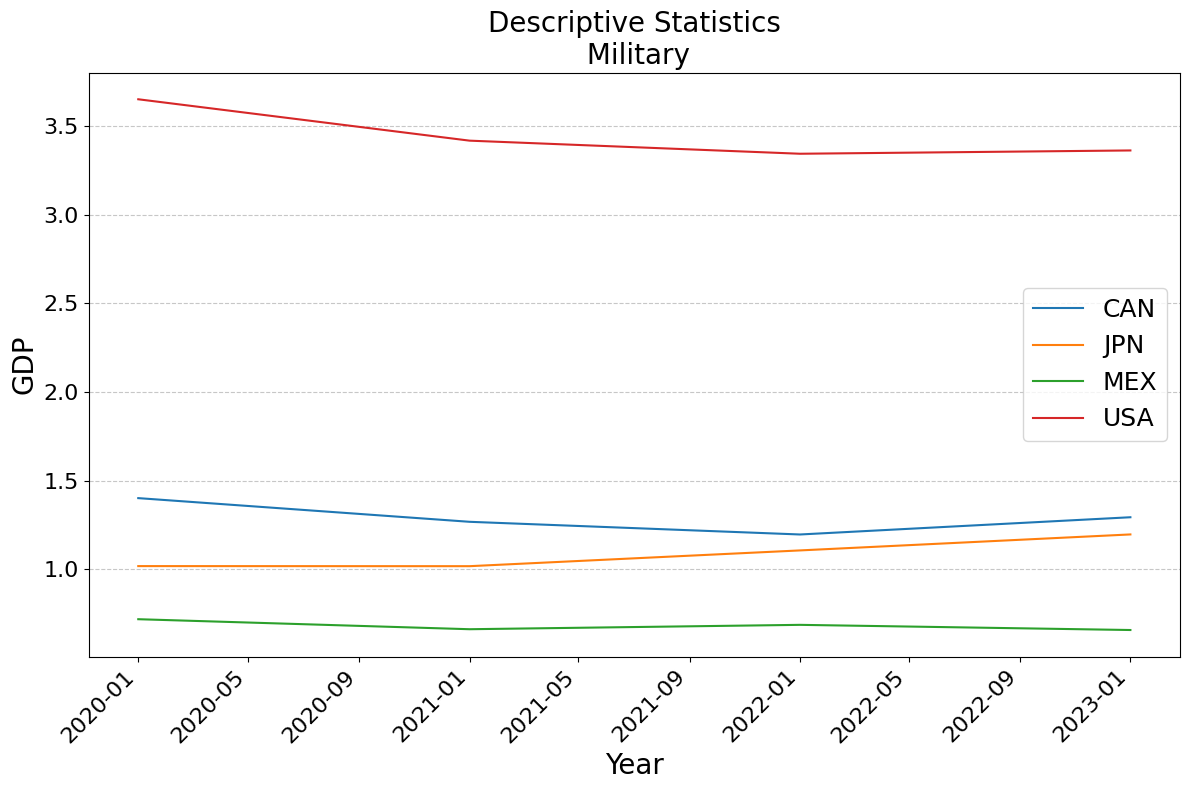

In [36]:
analyze.plot_timeseries(
     title = "Descriptive Statistics\n Military",
    filename = 'timeseries_military'
)

## 3.3 This class can and should be made into a python file

In [37]:
import sys
sys.path.append("../../../")
from src.data.pipeline_wb_descriptive import PipelineWBDescriptive as wb_pipe

In [38]:
analyze = wb_pipe(
    indicator = 'NY.GDP.PCAP.CD',
    countries=['US', 'CA', 'MX', 'JP'],
    date_start='2018',
    date_end='2023'
    )
analyze.download()
analyze.df.head(2)

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal,series
0,GDP per capita (current US$),Canada,CAN,2023-01-01,53431.185706,NaN,NaN,1,NY.GDP.PCAP.CD
1,GDP per capita (current US$),Canada,CAN,2022-01-01,55509.393176,NaN,NaN,1,NY.GDP.PCAP.CD


# Advanced for loop

In [39]:
indicator_descriptions = {
    'NY.GDP.PCAP.CD': 'GDP per capita (current US$)',
    'SP.POP.TOTL': 'Total population',
    'NE.EXP.GNFS.ZS': 'Exports of goods and services (% of GDP)',
    'NE.IMP.GNFS.ZS': 'Imports of goods and services (% of GDP)',
    'FI.RES.TOTL.DT.ZS': 'Total reserves (% of total external debt)',
    'FR.INR.LEND': 'Interest rate spread (lending rate minus deposit rate, %)',
    'GF.TAX.OTHR.GD.ZS': 'Taxes other than income, profits and capital gains (% of GDP)',
    'MS.MIL.XPND.GD.ZS': 'Military expenditure (% of GDP)',
    'SE.PRM.ENRR': 'Primary school enrollment (% gross)',
    'SE.SEC.ENRR': 'Secondary school enrollment (% gross)',
    'SL.UEM.TOTL.ZS': 'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'NV.AGR.TOTL.ZS': 'Agriculture, forestry, and fishing, value added (% of GDP)',
    'NV.IND.TOTL.ZS': 'Industry (including construction), value added (% of GDP)',
    'NV.SRV.TOTL.ZS': 'Services, value added (% of GDP)',
    'FP.CPI.TOTL.ZG': 'Inflation, consumer prices (annual %)',
    'BX.KLT.DINV.WD.GD.ZS': 'Foreign direct investment, net inflows (% of GDP)',
    'BM.KLT.DINV.WD.GD.ZS': 'Foreign direct investment, net outflows (% of GDP)',
    'DT.TDS.DECT.EX.ZS': 'Total debt service (% of exports of goods, services and primary income)',
    'ER.FEX.RMGN.ZS': 'Real effective exchange rate index (2010=100)',
    'EN.GHG.CO2.PC.CE.AR5': 'Carbon Emissions'
}


data save here: data/raw_NY.GDP.PCAP.CD.csv')
data save here: cleaned_NY.GDP.PCAP.CD.csv
time series saved here reports/NY.GDP.PCAP.CD


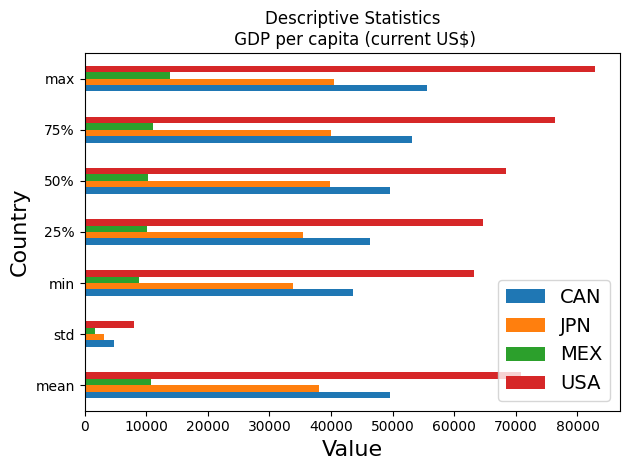

time series saved here reports/NY.GDP.PCAP.CD


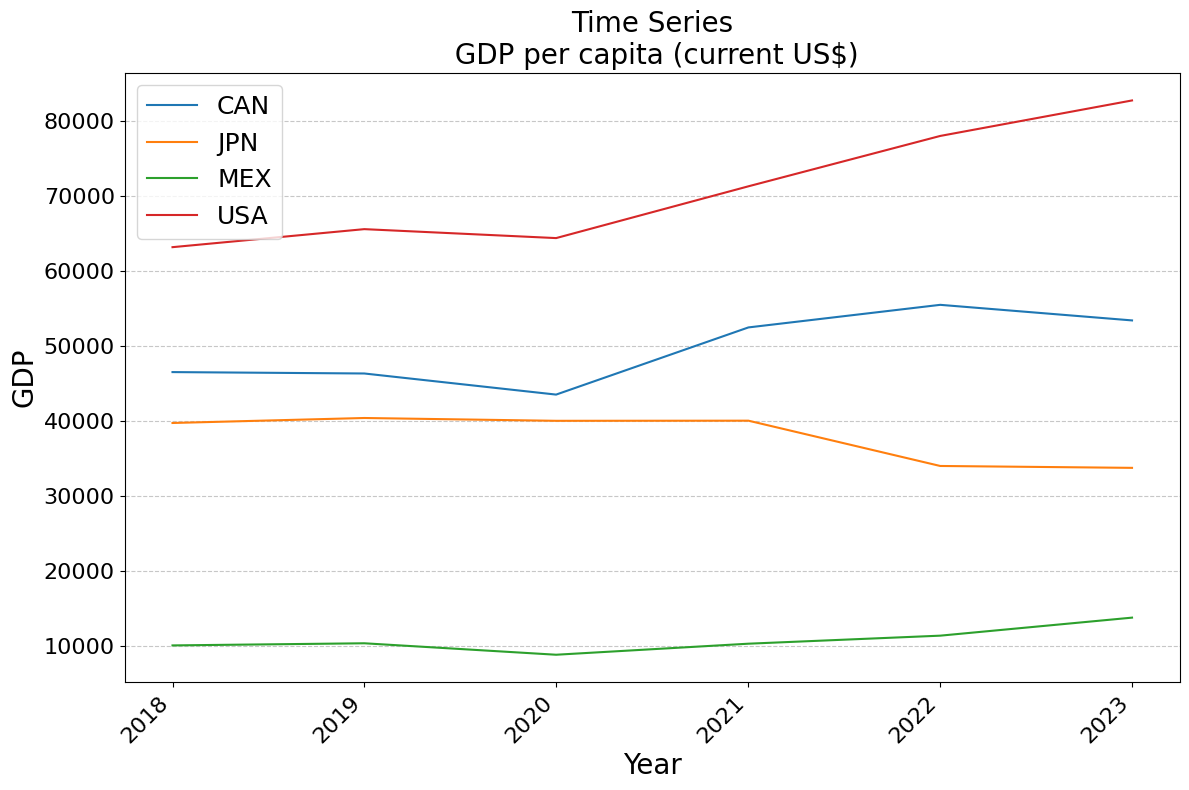

data save here: data/raw_SP.POP.TOTL.csv')
data save here: cleaned_SP.POP.TOTL.csv
time series saved here reports/SP.POP.TOTL


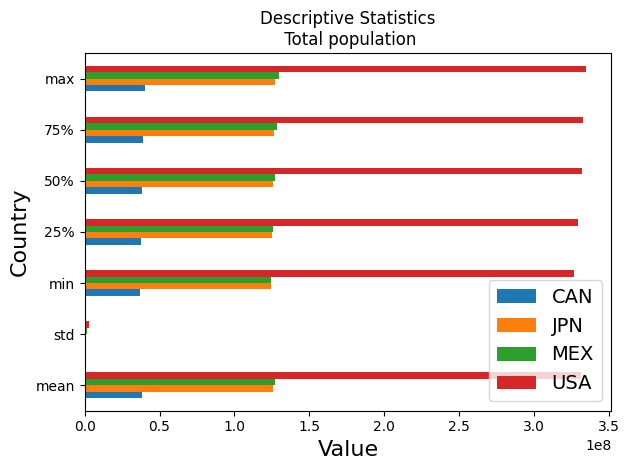

time series saved here reports/SP.POP.TOTL


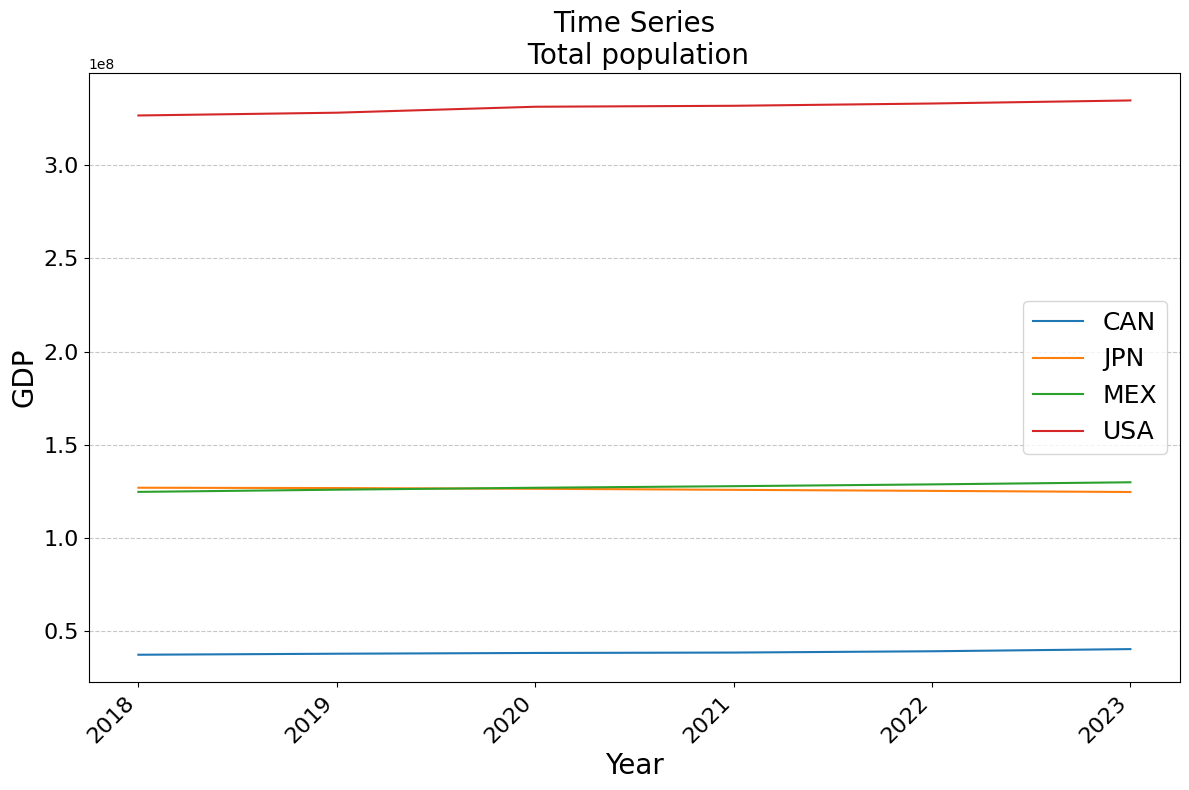

data save here: data/raw_NE.EXP.GNFS.ZS.csv')
data save here: cleaned_NE.EXP.GNFS.ZS.csv
time series saved here reports/NE.EXP.GNFS.ZS


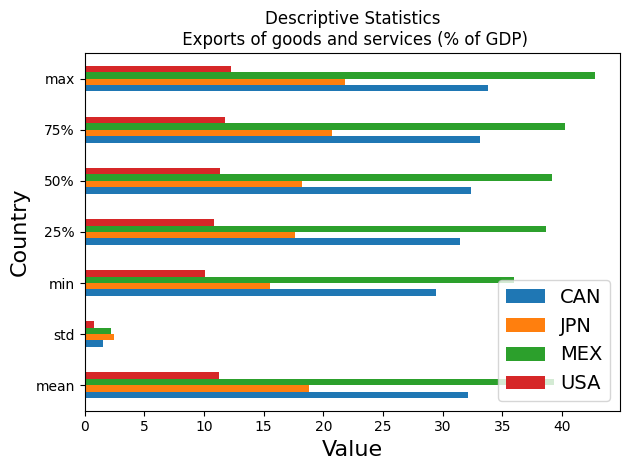

time series saved here reports/NE.EXP.GNFS.ZS


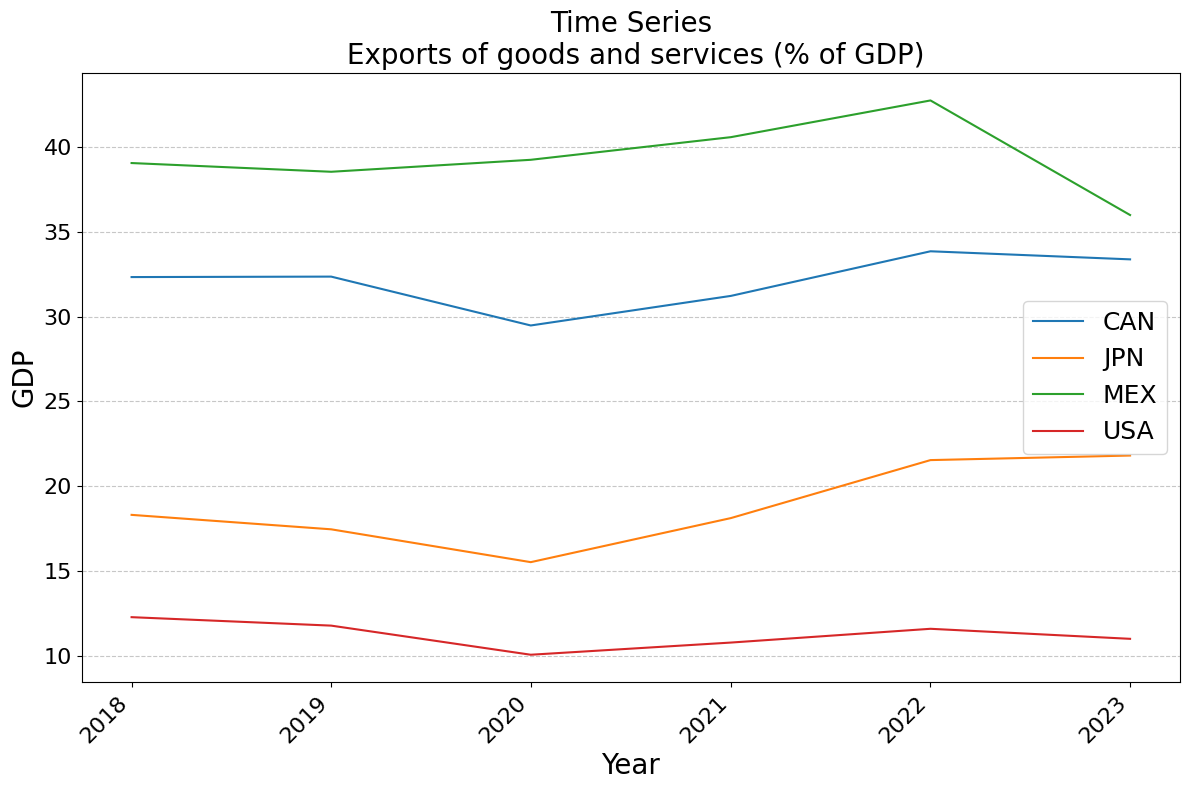

data save here: data/raw_NE.IMP.GNFS.ZS.csv')
data save here: cleaned_NE.IMP.GNFS.ZS.csv
time series saved here reports/NE.IMP.GNFS.ZS


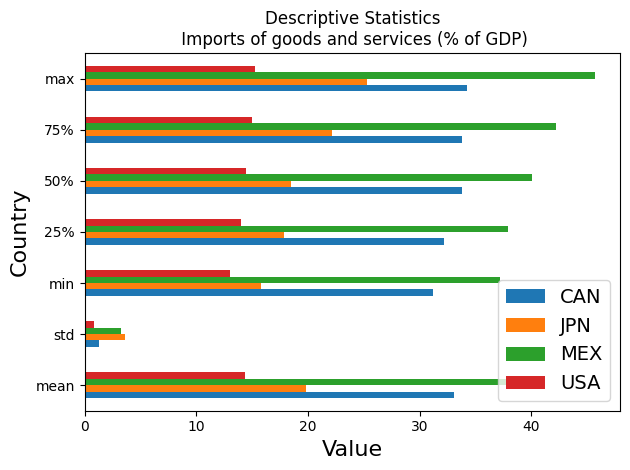

time series saved here reports/NE.IMP.GNFS.ZS


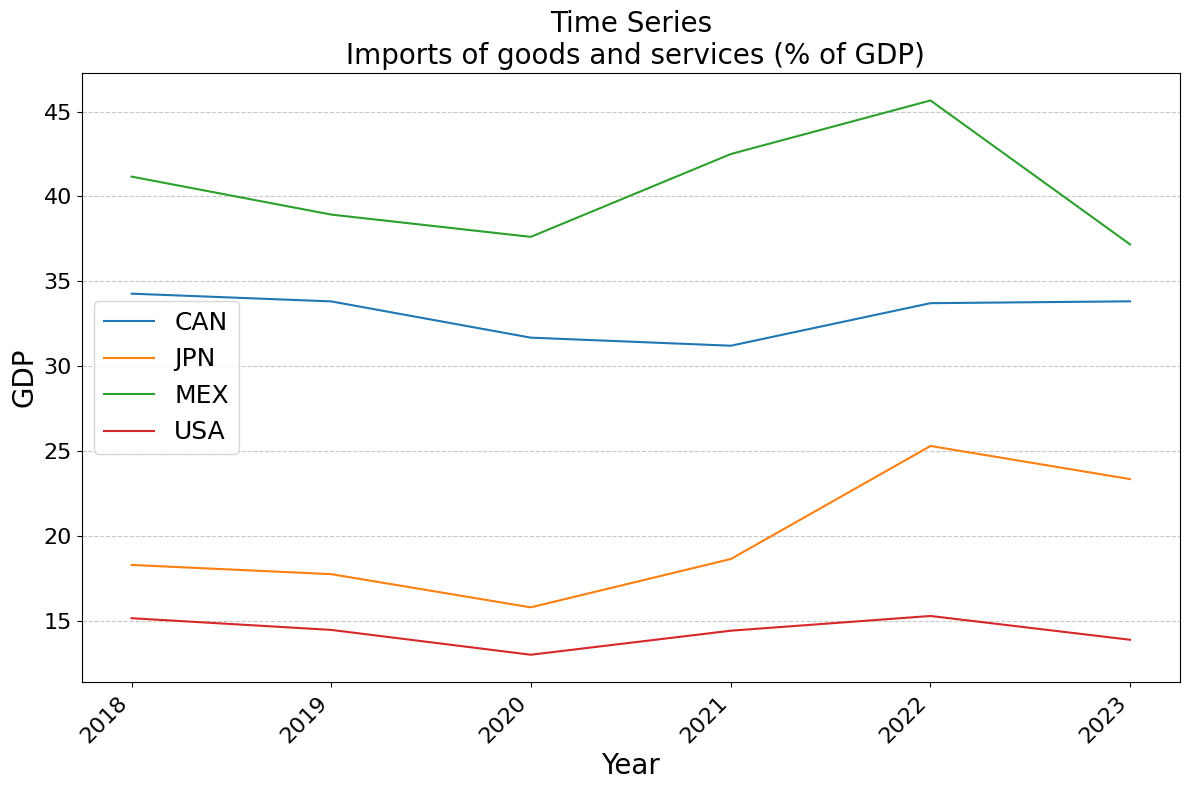

data save here: data/raw_FI.RES.TOTL.DT.ZS.csv')
data save here: cleaned_FI.RES.TOTL.DT.ZS.csv
time series saved here reports/FI.RES.TOTL.DT.ZS


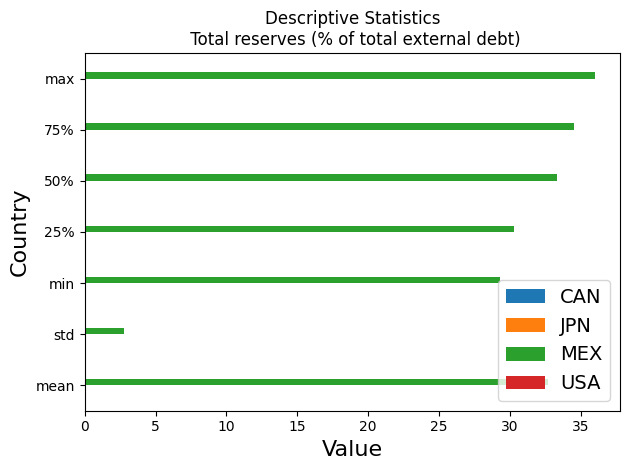

time series saved here reports/FI.RES.TOTL.DT.ZS


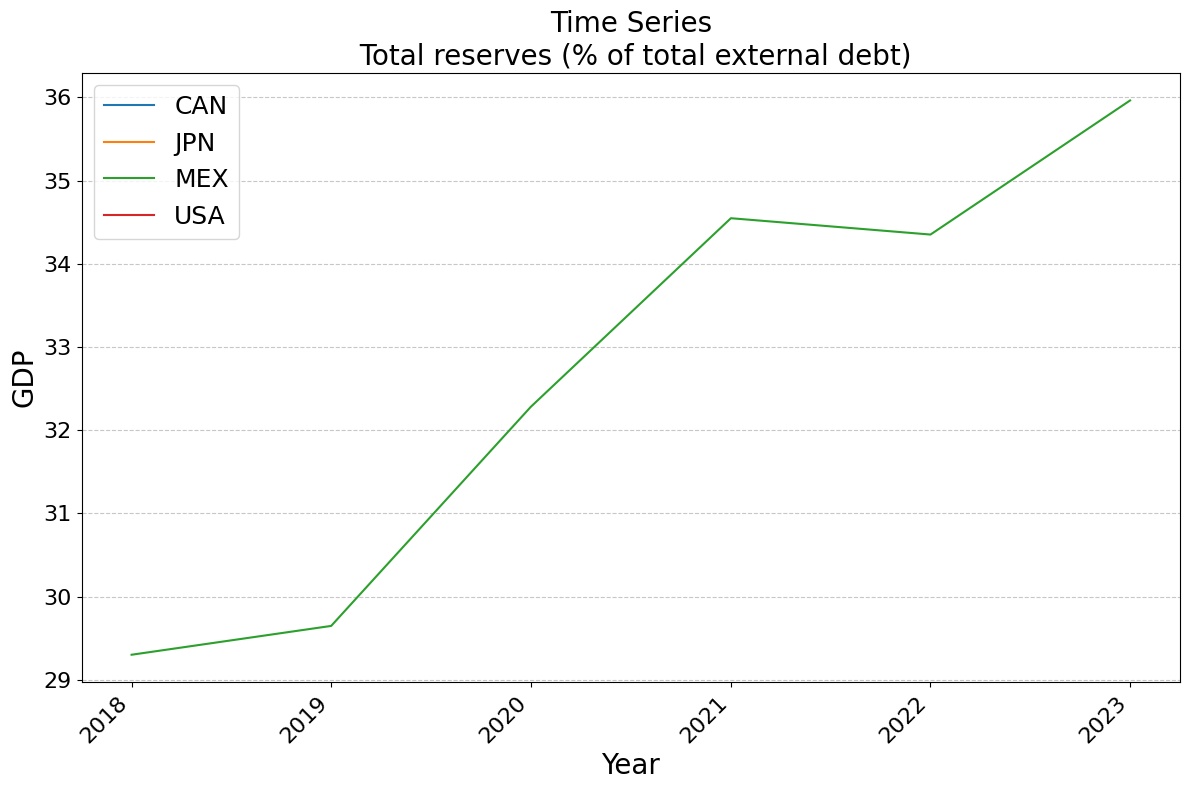

data save here: data/raw_FR.INR.LEND.csv')
data save here: cleaned_FR.INR.LEND.csv
time series saved here reports/FR.INR.LEND


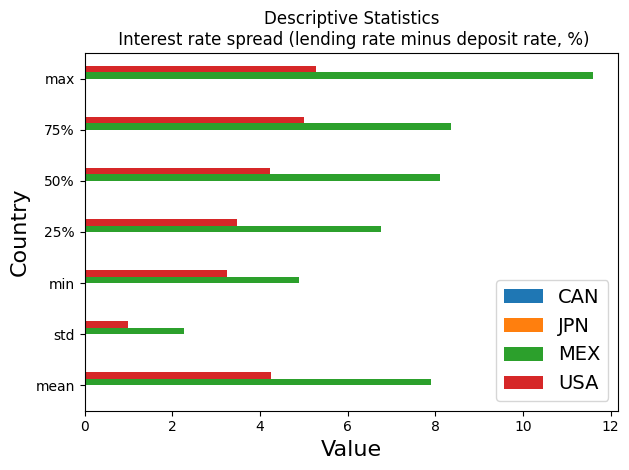

time series saved here reports/FR.INR.LEND


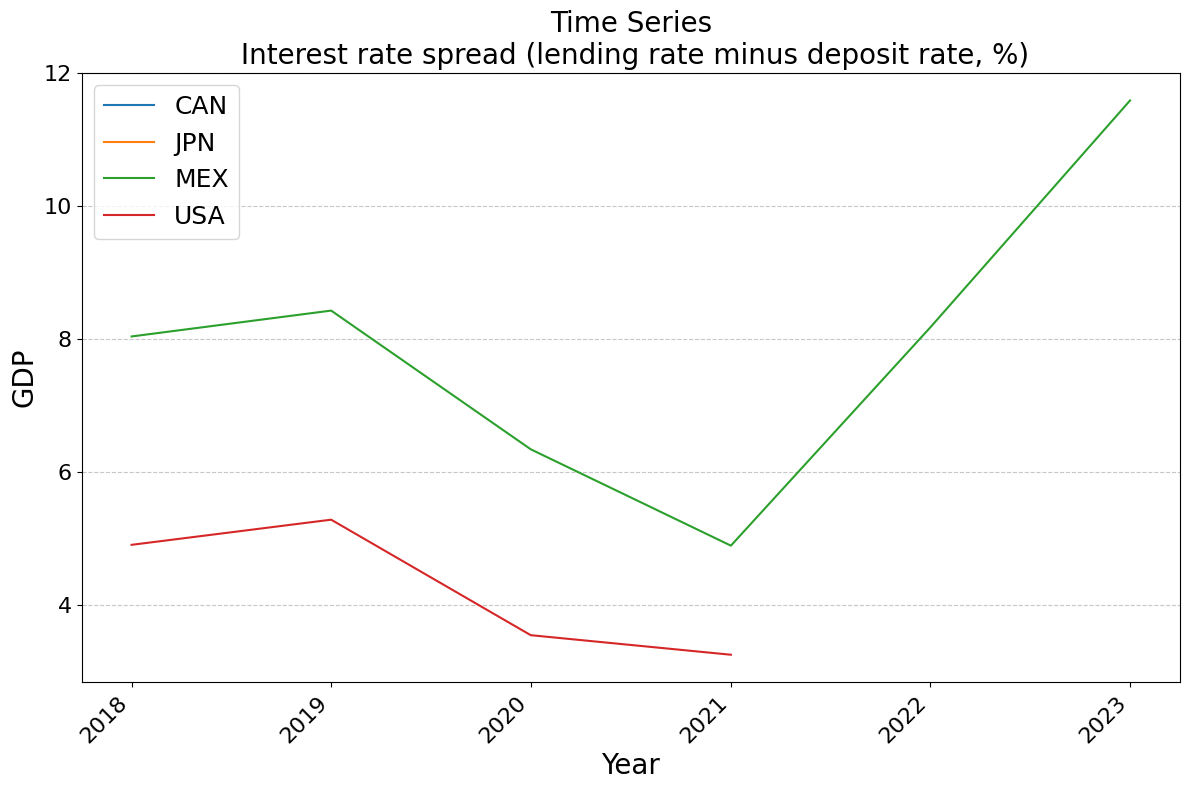

KeyError: 'date'

In [40]:
for indicator, description in indicator_descriptions.items():
    
    analyze = PipelineWBDescriptive(
    indicator = indicator,
    countries=['US', 'CA', 'MX', 'JP'],
    date_start='2018',
    date_end='2023'
    )
    
    df = analyze.download(save_data = True)
    df = analyze.pivot()
    df = analyze.rename_convert(save_data = True)
    analyze.plot_descriptive(
        title = f"Descriptive Statistics\n {description}",
        filename = indicator
    )
    analyze.plot_timeseries(
        title = f"Time Series\n {description}",
        filename = indicator
    )

## Can someone in class try to find metadata from the IMF/IFS data

In [41]:
import requests
import pandas as pd

def fetch_imf_data(indicator, startPeriod, endPeriod):
    url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
    key = f'CompactData/IFS/M..{indicator}?startPeriod={startPeriod}&endPeriod={endPeriod}'
    data = requests.get(f'{url}{key}').json()['CompactData']['DataSet']['Series']
    print(data)
    df_final = []
    for point in data:
        try:
            country = point['@REF_AREA']
            obs = point['Obs']
            df = pd.DataFrame(obs).assign(country=country)
            df_final.append(df)
        except:
            pass
            
    return pd.concat(df_final, axis=0).rename(columns={"@OBS_VALUE": indicator, "@TIME_PERIOD":"date"})

df_imf = fetch_imf_data('PCPI_IX', '2000', '2024')
df_imf.head(2)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,date,PCPI_IX,@OBS_STATUS,country
0,2000-01,83.8124105910346,NaN,BH
1,2000-02,83.6487144765991,NaN,BH
